# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


In [18]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
# Import your chosen baseline model
# Example: from sklearn.linear_model import LogisticRegression


## Model Choice

We chose SARIMAX as our baseline because it captures seasonality, autocorrelation, and the influence of external variables. Since electricity prices follow strong daily and weekly patterns and depend on factors like demand and weather, SARIMAX gives us a clear and interpretable starting point before exploring more complex models.


## Feature Selection

We use the features with the strongest and most meaningful correlations to the day‑ahead price. This includes residual load, fossil generation (lignite, gas, hard coal), pumped‑storage activity, cross‑border trading, biomass, and key renewable indicators such as solar, wind, and renewable shares. These variables capture the main drivers of price formation and provide a solid exogenous set for our SARIMAX baseline. To keep the baseline model simple, we only took the 2 most correlating values.


In [19]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt

drive.mount('/content/drive')

path = "/content/drive/MyDrive/Forcasting based on Energy Charts datasets/Energy_Charts_2025_January_to_June.csv"



# Load the dataset
#df = pd.read_csv(path, low_memory=False)
#df = df.fillna(0)
#df = df.loc[df['Date (GMT+1)'].notna()]

# Feature selection
#Residual load
#Fossil brown coal / lignite
#Renewable share of load
#Renewable share of generation

drop_cols = [
"Hydro pumped storage consumption",
"Cross border electricity trading",
"Nuclear",
"Hydro Run-of-River",
"Biomass",
"Fossil hard coal",
"Fossil oil",
"Fossil coal-derived gas",
"Fossil gas",
"Geothermal",
"Hydro water reservoir",
"Hydro pumped storage",
"Others",
"Waste",
"Wind offshore",
"Wind onshore",
"Solar",
"Load",
]

df = (
    pd.read_csv(path, low_memory=False)
      .fillna(0)
      .query("`Date (GMT+1)` == `Date (GMT+1)`")  # filter notna()
      .drop(columns=drop_cols)
)
df['Date (GMT+1)'] = pd.to_datetime(df['Date (GMT+1)'], infer_datetime_format=True)
df = df.set_index(['Date (GMT+1)'])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-4213395182.py:49: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date (GMT+1)'] = pd.to_datetime(df['Date (GMT+1)'], infer_datetime_format=True)
/tmp/ipython-input-4213395182.py:49: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['Date (GMT+1)'] = pd.to_datetime(df['Date (GMT+1)'], infer_datetime_format=True)


## Implementation





/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


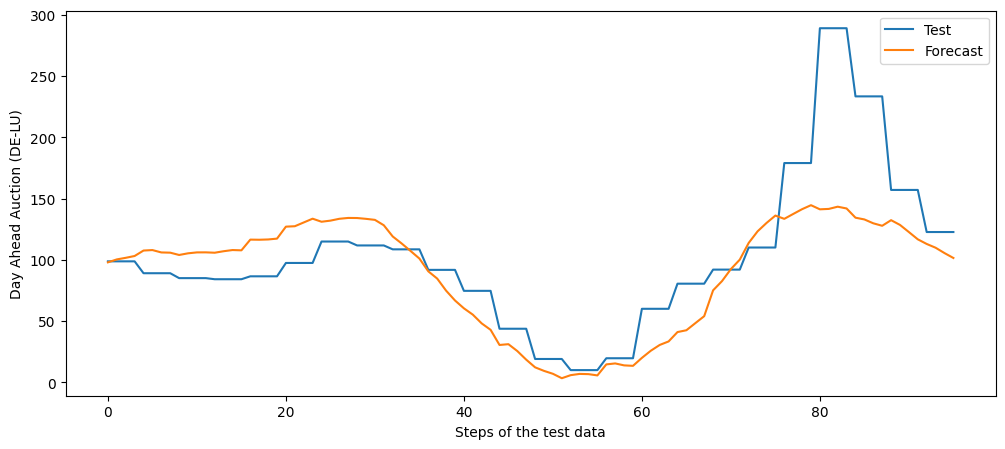

R²: 0.5312778357661425
MSE: 1790.9130885301245
MSAE: 2148291238.4881835
RMSE: 42.319181094748565


In [20]:
import random
random.seed(12345)

import numpy as np
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# --- Train/Test Split ---
train = df['Day Ahead Auction (DE-LU)'][-672:-96] #96 pro tag #672 pro woche  #2880 pro monat 30 tage
test  = df['Day Ahead Auction (DE-LU)'][-96:]

features = [
    'Residual load',
    'Fossil brown coal / lignite',
    'Renewable share of load',
    'Renewable share of generation'
]

exog_train = df[features].values[-672:-96]
exog_test  = df[features].values[-96:]

# --- SARIMAX Model ---
mod = sm.tsa.statespace.SARIMAX(
    endog=train,
    exog=exog_train,
    order=(0,1,1),
    seasonal_order=(1,1,1,52)
)

res = mod.fit(disp=False)

# --- Forecast ---
fcst = res.forecast(steps=96, exog=exog_test)

# --- Plot ---
plt.figure(figsize=(12,5))
plt.plot(test.values, label="Test")
plt.plot(fcst.values, label="Forecast")
plt.xlabel("Steps of the test data")
plt.ylabel("Day Ahead Auction (DE-LU)")
plt.legend()
plt.show()

# --- Metrics ---
def msae(y_true, y_pred):
    denom = np.abs(np.diff(y_true))
    denom = np.where(denom == 0, 1e-8, denom)
    scaled_errors = np.abs(y_true[1:] - y_pred[1:]) / denom
    return np.mean(scaled_errors)

r2  = r2_score(test, fcst)
mse = mean_squared_error(test, fcst)
msae_value = msae(test.values, fcst.values)
rmse = np.sqrt(mse)

print("R²:", r2)
print("MSE:", mse)
print("MSAE:", msae_value)
print("RMSE:",rmse)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


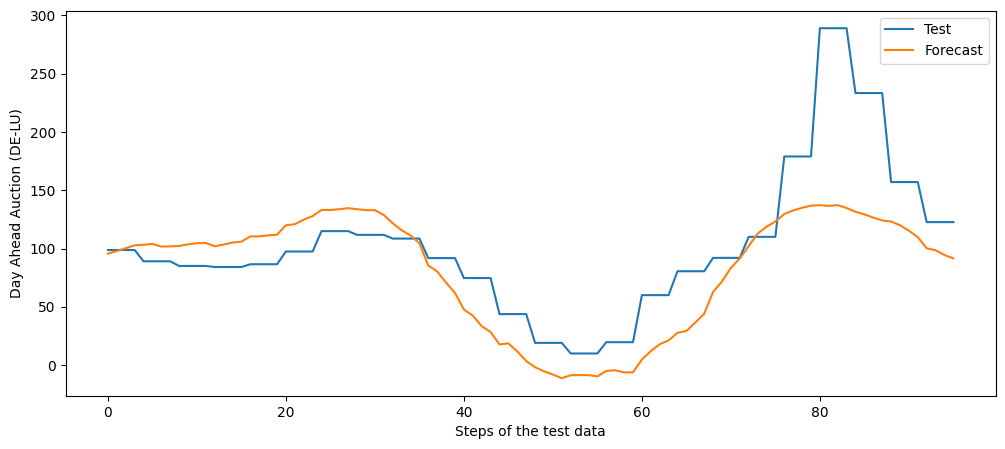

R²: 0.4433176195105727
MSE: 2126.9951315449384
MSAE: 2506086011.7254915
RMSE: 46.11935744939362


In [21]:
import random
random.seed(12345)

import numpy as np
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# --- Train/Test Split ---
train = df['Day Ahead Auction (DE-LU)'][-1344:-96] #96 pro tag #672 pro woche  #2880 pro monat 30 tage
test  = df['Day Ahead Auction (DE-LU)'][-96:]

features = [
    'Residual load',
    'Fossil brown coal / lignite',
    'Renewable share of load',
    'Renewable share of generation'
]

exog_train = df[features].values[-1344:-96]
exog_test  = df[features].values[-96:]

# --- SARIMAX Model ---
mod = sm.tsa.statespace.SARIMAX(
    endog=train,
    exog=exog_train,
    order=(0,1,1),
    seasonal_order=(1,1,1,52)
)

res = mod.fit(disp=False)

# --- Forecast ---
fcst = res.forecast(steps=96, exog=exog_test)

# --- Plot ---
plt.figure(figsize=(12,5))
plt.plot(test.values, label="Test")
plt.plot(fcst.values, label="Forecast")
plt.xlabel("Steps of the test data")
plt.ylabel("Day Ahead Auction (DE-LU)")
plt.legend()
plt.show()

# --- Metrics ---
def msae(y_true, y_pred):
    denom = np.abs(np.diff(y_true))
    denom = np.where(denom == 0, 1e-8, denom)
    scaled_errors = np.abs(y_true[1:] - y_pred[1:]) / denom
    return np.mean(scaled_errors)

r2  = r2_score(test, fcst)
mse = mean_squared_error(test, fcst)
msae_value = msae(test.values, fcst.values)
rmse = np.sqrt(mse)

print("R²:", r2)
print("MSE:", mse)
print("MSAE:", msae_value)
print("RMSE:",rmse)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


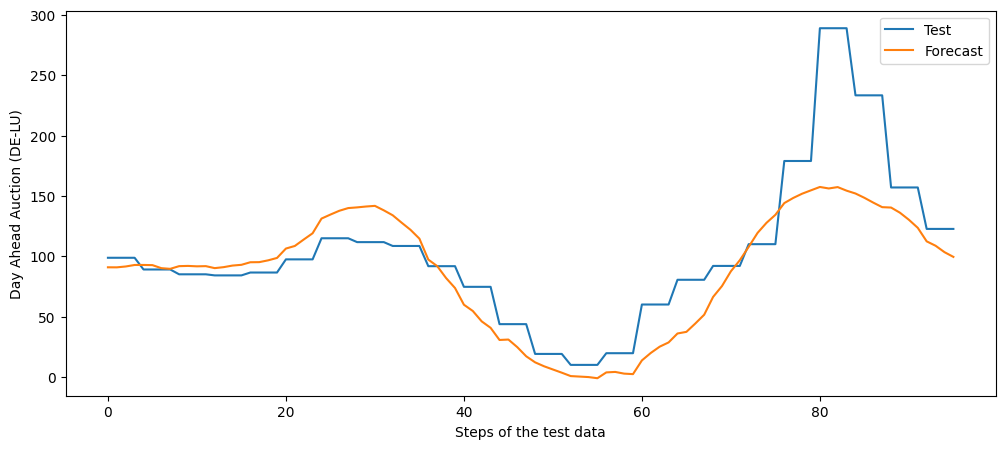

R²: 0.6272404679277302
MSE: 1424.2550828672138
MSAE: 1903296216.2467513
RMSE: 37.7393042181121


In [22]:
import random
random.seed(12345)

import numpy as np
import statsmodels.api as sm
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# --- Train/Test Split ---
train = df['Day Ahead Auction (DE-LU)'][-2880:-96]
test  = df['Day Ahead Auction (DE-LU)'][-96:]

features = [
    'Residual load',
    'Fossil brown coal / lignite',
    'Renewable share of load',
    'Renewable share of generation'
]

exog_train = df[features].values[-2880:-96]
exog_test  = df[features].values[-96:]

# --- SARIMAX Model ---
mod = sm.tsa.statespace.SARIMAX(
    endog=train,
    exog=exog_train,
    order=(0,1,1),
    seasonal_order=(1,1,1,52)
)

res = mod.fit(disp=False)

# --- Forecast ---
fcst = res.forecast(steps=96, exog=exog_test)

# --- Plot ---
plt.figure(figsize=(12,5))
plt.plot(test.values, label="Test")
plt.plot(fcst.values, label="Forecast")
plt.xlabel("Steps of the test data")
plt.ylabel("Day Ahead Auction (DE-LU)")
plt.legend()
plt.show()

# --- Metrics ---
def msae(y_true, y_pred):
    denom = np.abs(np.diff(y_true))
    denom = np.where(denom == 0, 1e-8, denom)
    scaled_errors = np.abs(y_true[1:] - y_pred[1:]) / denom
    return np.mean(scaled_errors)

r2  = r2_score(test, fcst)
mse = mean_squared_error(test, fcst)
msae_value = msae(test.values, fcst.values)
rmse = np.sqrt(mse)

print("R²:", r2)
print("MSE:", mse)
print("MSAE:", msae_value)
print("RMSE:",rmse)

## Evaluation



# Evaluate the baseline model

A RMSE of 80.5 means 80.5 EUR/MWh wrong in avarage

Range: 25-300 EUR/MWh

#Test data 1 week
MSE: 1790.9130885301245

RMSE: 42.319181094748565

#Test data 2 weeks
MSE: 2126.9951315449384

RMSE: 46.11935744939362

#Test data 4 weeks
MSE: 1424.2550828672138

RMSE: 37.7393042181121